In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [2]:
!unzip /home/workspace/data/bitcoin-historical-data.zip 

Archive:  /home/workspace/data/bitcoin-historical-data.zip
  inflating: bitstampUSD_1-min_data_2012-01-01_to_2019-08-12.csv  
  inflating: coinbaseUSD_1-min_data_2014-12-01_to_2019-01-09.csv  


In [2]:
import pandas as pd
df = pd.read_csv("coinbaseUSD_1-min_data_2014-12-01_to_2019-01-09.csv")

# add rolling window 2d processor

In [3]:
def rolling_window_2d(a, window):
    nrow, ncol = a.shape
    shape = nrow - window, window, ncol
    strides = a.strides[0], a.strides[0], a.strides[-1]
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

# create generator for training
I use all of columns for predict the next diff, but data scale is not static, so I standardize it.

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime 

## add some constant

In [5]:
columns = ["Open", "High", "Low", "Close", "Volume_(Currency)"]
window = 20
how = {
    "Open": 'first',
    "High": 'max',
    "Low": "min",
    "Close": "last",
    "Volume_(Currency)": 'sum'
}


## set dataframe index to unixtimestamp

In [6]:
df.loc[:, "datetime"] = pd.to_datetime(df["Timestamp"], unit='s')
df = df.set_index("datetime")

## create 60min resolution dataframe

In [7]:
df_60min = df.resample("60min", how=how)
df_train = df_60min[columns]
df_train = df_train.bfill()
diff = df_train.diff()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...)..apply(<func>)
  """Entry point for launching an IPython kernel.


## use valid data. (I think 2015~2017 data is not good for predict)

In [8]:
df = diff[datetime(2017, 7, 1):]
df

,Open,High,Low,Close,Volume_(Currency)
datetime,,,,,
2017-07-01 00:00:00,2.19,8.43,6.03,5.84,-1.164132e+06
2017-07-01 01:00:00,5.85,0.90,-11.16,-19.92,1.459702e+05
2017-07-01 02:00:00,-19.95,-25.09,-13.04,-3.24,1.996594e+05
2017-07-01 03:00:00,-2.75,0.91,4.11,-1.76,-4.094932e+05
2017-07-01 04:00:00,-2.23,17.27,-1.34,26.31,-2.574444e+03
...,...,...,...,...,...
2019-01-07 18:00:00,-4.01,3.52,35.72,0.43,-1.021929e+06
2019-01-07 19:00:00,-0.45,-5.52,3.23,8.44,-3.768007e+05
2019-01-07 20:00:00,8.45,1.00,-15.00,-17.28,1.586159e+06


## del nan

In [9]:
diff = df.dropna()
train_diff = diff[:4*len(diff)//6]
valid_diff = diff[4*len(diff)//6:5*len(diff)//6]
test_diff = diff[5*len(diff)//6:]



## create rolling window numpy matrix.

In [10]:
train_diff_rolling_window = rolling_window_2d(a=train_diff.values, window=window)
valid_diff_rolling_window = rolling_window_2d(a=valid_diff.values, window=window)

## create data generator
Min max normalizing to improve predict

y = close price of next

x = all value

In [11]:
def min_max(x, axis=None):
    min = x.min(axis=axis, keepdims=True)
    max = x.max(axis=axis, keepdims=True)
    result = (x-min)/(max-min)
    return result

In [12]:
from torch.utils.data import DataLoader
from scipy import stats
def collate_fn(data):
    winz = np.array(data)
    winz = min_max(winz, axis=1)
    y = winz[:, -1, 3]
    x = winz[:, :-1]
    if cuda:
        return torch.tensor(x, dtype=torch.float32, device='cuda'), torch.tensor(y, dtype=torch.float32, device='cuda')
    else:
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)
    
        

## create GRU network via pytorch 

In [13]:
import torch.nn as nn
from torch import zeros
import torch
from torch import optim
import torch.nn.functional as F
class GRUNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, drop_prob=0.5):
        super(GRUNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        self.gru = nn.GRU(input_dim, hidden_dim, n_layers, batch_first=True, dropout=drop_prob)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()
        

        
    def forward(self, x, h=None):
        out, h = self.gru(x, h)
        out = self.sigmoid(self.fc(self.relu(out[:,-1])))
        return out
    

In [14]:
from tqdm.notebook import tqdm
input_dim = 5
hidden_dim = 128
n_layer = 5  # ONLY CHANGE IS HERE FROM ONE LAYER TO TWO LAYER
output_dim = 1
epoch = 100
batch_size = 32
cuda = True if torch.cuda.is_available() else False
model = GRUNet(input_dim=input_dim, hidden_dim=hidden_dim, n_layers=n_layer, output_dim=output_dim)
loss_function = nn.BCELoss()
optimizer= optim.Adam(model.parameters(), lr=1e-3)
train_data = DataLoader(train_diff_rolling_window , batch_size=batch_size, collate_fn=collate_fn)
valid_data = DataLoader(valid_diff_rolling_window , batch_size=batch_size//2, collate_fn=collate_fn)
data = dict(train=train_data, valid=valid_data)
hidden_tensor = zeros(5, batch_size, hidden_dim)

# Train gru network

In [17]:
epoch = 200

print(hidden_tensor.shape)
if cuda:
    model.cuda()
    hidden_tensor = hidden_tensor.float().cuda()
else:
    hidden_tensor = hidden_tensor
hidden = nn.Parameter(hidden_tensor, requires_grad=True)

for n in range(epoch):
    print('Epoch {}/{}'.format(n, epoch - 1))
    print('-' * 10)

    for phase in ["train", "valid"]:
        if phase == "train":
            model.train(True)
        else:
            model.train(False)
        epoch_loss = 0
        for x, y in tqdm(data[phase]):
            model.zero_grad()
            train_outputs = model(x) # batch size x time steps x feature_num
            loss = loss_function(train_outputs, y)
            optimizer.zero_grad()
            if phase == "train":
                loss.backward()
                optimizer.step()
            epoch_loss += loss
        epoch_loss = epoch_loss / len(data[phase])
        print('EPOCH: ', str(n), 'phase: ', phase, ' loss :', epoch_loss)

torch.Size([5, 32, 128])
Epoch 0/199
----------


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)



EPOCH:  0 phase:  train  loss : tensor(0.6720, device='cuda:0', grad_fn=<DivBackward0>)


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([11])) that is different to the input size (torch.Size([11, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)



EPOCH:  0 phase:  valid  loss : tensor(0.6358, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 1/199
----------


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([12])) that is different to the input size (torch.Size([12, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)



EPOCH:  1 phase:  train  loss : tensor(0.6577, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  1 phase:  valid  loss : tensor(0.6334, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 2/199
----------



EPOCH:  2 phase:  train  loss : tensor(0.6528, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  2 phase:  valid  loss : tensor(0.6258, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 3/199
----------



EPOCH:  3 phase:  train  loss : tensor(0.6518, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  3 phase:  valid  loss : tensor(0.6256, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 4/199
----------



EPOCH:  4 phase:  train  loss : tensor(0.6496, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  4 phase:  valid  loss : tensor(0.6326, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 5/199
----------



EPOCH:  5 phase:  train  loss : tensor(0.6485, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  5 phase:  valid  loss : tensor(0.6265, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 6/199
----------



EPOCH:  6 phase:  train  loss : tensor(0.6458, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  6 phase:  valid  loss : tensor(0.6219, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 7/199
----------



EPOCH:  7 phase:  train  loss : tensor(0.6460, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  7 phase:  valid  loss : tensor(0.6266, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 8/199
----------



EPOCH:  8 phase:  train  loss : tensor(0.6436, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  8 phase:  valid  loss : tensor(0.6246, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 9/199
----------



EPOCH:  9 phase:  train  loss : tensor(0.6431, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  9 phase:  valid  loss : tensor(0.6252, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 10/199
----------



EPOCH:  10 phase:  train  loss : tensor(0.6431, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  10 phase:  valid  loss : tensor(0.6256, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 11/199
----------



EPOCH:  11 phase:  train  loss : tensor(0.6429, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  11 phase:  valid  loss : tensor(0.6306, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 12/199
----------



EPOCH:  12 phase:  train  loss : tensor(0.6399, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  12 phase:  valid  loss : tensor(0.6301, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 13/199
----------



EPOCH:  13 phase:  train  loss : tensor(0.6413, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  13 phase:  valid  loss : tensor(0.6417, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 14/199
----------



EPOCH:  14 phase:  train  loss : tensor(0.6379, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  14 phase:  valid  loss : tensor(0.6303, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 15/199
----------



EPOCH:  15 phase:  train  loss : tensor(0.6406, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  15 phase:  valid  loss : tensor(0.6248, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 16/199
----------



EPOCH:  16 phase:  train  loss : tensor(0.6447, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  16 phase:  valid  loss : tensor(0.6280, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 17/199
----------



EPOCH:  17 phase:  train  loss : tensor(0.6387, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  17 phase:  valid  loss : tensor(0.6266, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 18/199
----------



EPOCH:  18 phase:  train  loss : tensor(0.6361, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  18 phase:  valid  loss : tensor(0.6222, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 19/199
----------



EPOCH:  19 phase:  train  loss : tensor(0.6397, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  19 phase:  valid  loss : tensor(0.6224, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 20/199
----------



EPOCH:  20 phase:  train  loss : tensor(0.6372, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  20 phase:  valid  loss : tensor(0.6358, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 21/199
----------



EPOCH:  21 phase:  train  loss : tensor(0.6372, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  21 phase:  valid  loss : tensor(0.6317, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 22/199
----------



EPOCH:  22 phase:  train  loss : tensor(0.6339, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  22 phase:  valid  loss : tensor(0.6267, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 23/199
----------



EPOCH:  23 phase:  train  loss : tensor(0.6365, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  23 phase:  valid  loss : tensor(0.6329, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 24/199
----------



EPOCH:  24 phase:  train  loss : tensor(0.6385, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  24 phase:  valid  loss : tensor(0.6154, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 25/199
----------



EPOCH:  25 phase:  train  loss : tensor(0.6334, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  25 phase:  valid  loss : tensor(0.6313, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 26/199
----------



EPOCH:  26 phase:  train  loss : tensor(0.6332, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  26 phase:  valid  loss : tensor(0.6188, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 27/199
----------



EPOCH:  27 phase:  train  loss : tensor(0.6321, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  27 phase:  valid  loss : tensor(0.6214, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 28/199
----------



EPOCH:  28 phase:  train  loss : tensor(0.6344, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  28 phase:  valid  loss : tensor(0.6257, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 29/199
----------



EPOCH:  29 phase:  train  loss : tensor(0.6300, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  29 phase:  valid  loss : tensor(0.6217, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 30/199
----------



EPOCH:  30 phase:  train  loss : tensor(0.6301, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  30 phase:  valid  loss : tensor(0.6173, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 31/199
----------



EPOCH:  31 phase:  train  loss : tensor(0.6279, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  31 phase:  valid  loss : tensor(0.6264, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 32/199
----------



EPOCH:  32 phase:  train  loss : tensor(0.6306, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  32 phase:  valid  loss : tensor(0.6245, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 33/199
----------



EPOCH:  33 phase:  train  loss : tensor(0.6267, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  33 phase:  valid  loss : tensor(0.6275, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 34/199
----------



EPOCH:  34 phase:  train  loss : tensor(0.6248, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  34 phase:  valid  loss : tensor(0.6273, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 35/199
----------



EPOCH:  35 phase:  train  loss : tensor(0.6311, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  35 phase:  valid  loss : tensor(0.6234, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 36/199
----------



EPOCH:  36 phase:  train  loss : tensor(0.6247, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  36 phase:  valid  loss : tensor(0.6214, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 37/199
----------



EPOCH:  37 phase:  train  loss : tensor(0.6253, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  37 phase:  valid  loss : tensor(0.6233, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 38/199
----------



EPOCH:  38 phase:  train  loss : tensor(0.6262, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  38 phase:  valid  loss : tensor(0.6286, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 39/199
----------



EPOCH:  39 phase:  train  loss : tensor(0.6271, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  39 phase:  valid  loss : tensor(0.6266, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 40/199
----------



EPOCH:  40 phase:  train  loss : tensor(0.6254, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  40 phase:  valid  loss : tensor(0.6250, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 41/199
----------



EPOCH:  41 phase:  train  loss : tensor(0.6284, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  41 phase:  valid  loss : tensor(0.6306, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 42/199
----------



EPOCH:  42 phase:  train  loss : tensor(0.6245, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  42 phase:  valid  loss : tensor(0.6362, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 43/199
----------



EPOCH:  43 phase:  train  loss : tensor(0.6221, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  43 phase:  valid  loss : tensor(0.6361, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 44/199
----------



EPOCH:  44 phase:  train  loss : tensor(0.6261, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  44 phase:  valid  loss : tensor(0.6202, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 45/199
----------



EPOCH:  45 phase:  train  loss : tensor(0.6264, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  45 phase:  valid  loss : tensor(0.6246, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 46/199
----------



EPOCH:  46 phase:  train  loss : tensor(0.6212, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  46 phase:  valid  loss : tensor(0.6282, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 47/199
----------



EPOCH:  47 phase:  train  loss : tensor(0.6214, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  47 phase:  valid  loss : tensor(0.6299, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 48/199
----------



EPOCH:  48 phase:  train  loss : tensor(0.6192, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  48 phase:  valid  loss : tensor(0.6275, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 49/199
----------



EPOCH:  49 phase:  train  loss : tensor(0.6227, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  49 phase:  valid  loss : tensor(0.6300, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 50/199
----------



EPOCH:  50 phase:  train  loss : tensor(0.6176, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  50 phase:  valid  loss : tensor(0.6270, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 51/199
----------



EPOCH:  51 phase:  train  loss : tensor(0.6233, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  51 phase:  valid  loss : tensor(0.6350, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 52/199
----------



EPOCH:  52 phase:  train  loss : tensor(0.6166, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  52 phase:  valid  loss : tensor(0.6319, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 53/199
----------



EPOCH:  53 phase:  train  loss : tensor(0.6186, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  53 phase:  valid  loss : tensor(0.6532, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 54/199
----------



EPOCH:  54 phase:  train  loss : tensor(0.6186, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  54 phase:  valid  loss : tensor(0.6352, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 55/199
----------



EPOCH:  55 phase:  train  loss : tensor(0.6212, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  55 phase:  valid  loss : tensor(0.6169, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 56/199
----------



EPOCH:  56 phase:  train  loss : tensor(0.6197, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  56 phase:  valid  loss : tensor(0.6354, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 57/199
----------



EPOCH:  57 phase:  train  loss : tensor(0.6185, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  57 phase:  valid  loss : tensor(0.6429, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 58/199
----------



EPOCH:  58 phase:  train  loss : tensor(0.6289, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  58 phase:  valid  loss : tensor(0.6321, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 59/199
----------



EPOCH:  59 phase:  train  loss : tensor(0.6165, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  59 phase:  valid  loss : tensor(0.6346, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 60/199
----------



EPOCH:  60 phase:  train  loss : tensor(0.6196, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  60 phase:  valid  loss : tensor(0.6335, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 61/199
----------



EPOCH:  61 phase:  train  loss : tensor(0.6185, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  61 phase:  valid  loss : tensor(0.6398, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 62/199
----------



EPOCH:  62 phase:  train  loss : tensor(0.6166, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  62 phase:  valid  loss : tensor(0.6277, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 63/199
----------



EPOCH:  63 phase:  train  loss : tensor(0.6173, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  63 phase:  valid  loss : tensor(0.6357, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 64/199
----------



EPOCH:  64 phase:  train  loss : tensor(0.6154, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  64 phase:  valid  loss : tensor(0.6313, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 65/199
----------



EPOCH:  65 phase:  train  loss : tensor(0.6129, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  65 phase:  valid  loss : tensor(0.6397, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 66/199
----------



EPOCH:  66 phase:  train  loss : tensor(0.6141, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  66 phase:  valid  loss : tensor(0.6345, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 67/199
----------



EPOCH:  67 phase:  train  loss : tensor(0.6215, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  67 phase:  valid  loss : tensor(0.6276, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 68/199
----------



EPOCH:  68 phase:  train  loss : tensor(0.6123, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  68 phase:  valid  loss : tensor(0.6389, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 69/199
----------



EPOCH:  69 phase:  train  loss : tensor(0.6153, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  69 phase:  valid  loss : tensor(0.6358, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 70/199
----------



EPOCH:  70 phase:  train  loss : tensor(0.6163, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  70 phase:  valid  loss : tensor(0.6488, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 71/199
----------



EPOCH:  71 phase:  train  loss : tensor(0.6191, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  71 phase:  valid  loss : tensor(0.6326, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 72/199
----------



EPOCH:  72 phase:  train  loss : tensor(0.6188, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  72 phase:  valid  loss : tensor(0.6290, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 73/199
----------



EPOCH:  73 phase:  train  loss : tensor(0.6096, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  73 phase:  valid  loss : tensor(0.6354, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 74/199
----------



EPOCH:  74 phase:  train  loss : tensor(0.6134, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  74 phase:  valid  loss : tensor(0.6403, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 75/199
----------



EPOCH:  75 phase:  train  loss : tensor(0.6140, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  75 phase:  valid  loss : tensor(0.6338, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 76/199
----------



EPOCH:  76 phase:  train  loss : tensor(0.6112, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  76 phase:  valid  loss : tensor(0.6312, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 77/199
----------



EPOCH:  77 phase:  train  loss : tensor(0.6105, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  77 phase:  valid  loss : tensor(0.6370, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 78/199
----------



EPOCH:  78 phase:  train  loss : tensor(0.6077, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  78 phase:  valid  loss : tensor(0.6407, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 79/199
----------



EPOCH:  79 phase:  train  loss : tensor(0.6109, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  79 phase:  valid  loss : tensor(0.6451, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 80/199
----------



EPOCH:  80 phase:  train  loss : tensor(0.6091, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  80 phase:  valid  loss : tensor(0.6534, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 81/199
----------



EPOCH:  81 phase:  train  loss : tensor(0.6088, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  81 phase:  valid  loss : tensor(0.6894, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 82/199
----------



EPOCH:  82 phase:  train  loss : tensor(0.6127, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  82 phase:  valid  loss : tensor(0.6373, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 83/199
----------



EPOCH:  83 phase:  train  loss : tensor(0.6083, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  83 phase:  valid  loss : tensor(0.6390, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 84/199
----------



EPOCH:  84 phase:  train  loss : tensor(0.6105, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  84 phase:  valid  loss : tensor(0.6386, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 85/199
----------



EPOCH:  85 phase:  train  loss : tensor(0.6077, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  85 phase:  valid  loss : tensor(0.6501, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 86/199
----------



EPOCH:  86 phase:  train  loss : tensor(0.6080, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  86 phase:  valid  loss : tensor(0.6438, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 87/199
----------



EPOCH:  87 phase:  train  loss : tensor(0.6061, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  87 phase:  valid  loss : tensor(0.6405, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 88/199
----------



EPOCH:  88 phase:  train  loss : tensor(0.6099, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  88 phase:  valid  loss : tensor(0.6497, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 89/199
----------



EPOCH:  89 phase:  train  loss : tensor(0.6060, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  89 phase:  valid  loss : tensor(0.6507, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 90/199
----------



EPOCH:  90 phase:  train  loss : tensor(0.6064, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  90 phase:  valid  loss : tensor(0.6354, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 91/199
----------



EPOCH:  91 phase:  train  loss : tensor(0.6117, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  91 phase:  valid  loss : tensor(0.6334, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 92/199
----------



EPOCH:  92 phase:  train  loss : tensor(0.6031, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  92 phase:  valid  loss : tensor(0.6638, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 93/199
----------



EPOCH:  93 phase:  train  loss : tensor(0.6059, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  93 phase:  valid  loss : tensor(0.6439, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 94/199
----------



EPOCH:  94 phase:  train  loss : tensor(0.6052, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  94 phase:  valid  loss : tensor(0.6524, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 95/199
----------



EPOCH:  95 phase:  train  loss : tensor(0.6009, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  95 phase:  valid  loss : tensor(0.6545, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 96/199
----------



EPOCH:  96 phase:  train  loss : tensor(0.6090, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  96 phase:  valid  loss : tensor(0.6341, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 97/199
----------



EPOCH:  97 phase:  train  loss : tensor(0.6057, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  97 phase:  valid  loss : tensor(0.6379, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 98/199
----------



EPOCH:  98 phase:  train  loss : tensor(0.6055, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  98 phase:  valid  loss : tensor(0.6283, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 99/199
----------



EPOCH:  99 phase:  train  loss : tensor(0.6080, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  99 phase:  valid  loss : tensor(0.6491, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 100/199
----------



EPOCH:  100 phase:  train  loss : tensor(0.6001, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  100 phase:  valid  loss : tensor(0.6586, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 101/199
----------



EPOCH:  101 phase:  train  loss : tensor(0.6014, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  101 phase:  valid  loss : tensor(0.6807, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 102/199
----------



EPOCH:  102 phase:  train  loss : tensor(0.5992, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  102 phase:  valid  loss : tensor(0.6654, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 103/199
----------



EPOCH:  103 phase:  train  loss : tensor(0.6082, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  103 phase:  valid  loss : tensor(0.6511, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 104/199
----------



EPOCH:  104 phase:  train  loss : tensor(0.5977, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  104 phase:  valid  loss : tensor(0.6464, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 105/199
----------



EPOCH:  105 phase:  train  loss : tensor(0.5961, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  105 phase:  valid  loss : tensor(0.6479, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 106/199
----------



EPOCH:  106 phase:  train  loss : tensor(0.5978, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  106 phase:  valid  loss : tensor(0.6613, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 107/199
----------



EPOCH:  107 phase:  train  loss : tensor(0.5985, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  107 phase:  valid  loss : tensor(0.6686, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 108/199
----------



EPOCH:  108 phase:  train  loss : tensor(0.6029, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  108 phase:  valid  loss : tensor(0.6552, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 109/199
----------



EPOCH:  109 phase:  train  loss : tensor(0.5971, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  109 phase:  valid  loss : tensor(0.6433, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 110/199
----------



EPOCH:  110 phase:  train  loss : tensor(0.6021, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  110 phase:  valid  loss : tensor(0.6622, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 111/199
----------



EPOCH:  111 phase:  train  loss : tensor(0.5975, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  111 phase:  valid  loss : tensor(0.6827, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 112/199
----------



EPOCH:  112 phase:  train  loss : tensor(0.6009, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  112 phase:  valid  loss : tensor(0.6396, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 113/199
----------



EPOCH:  113 phase:  train  loss : tensor(0.6046, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  113 phase:  valid  loss : tensor(0.6584, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 114/199
----------



EPOCH:  114 phase:  train  loss : tensor(0.5964, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  114 phase:  valid  loss : tensor(0.6537, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 115/199
----------



EPOCH:  115 phase:  train  loss : tensor(0.5975, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  115 phase:  valid  loss : tensor(0.6599, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 116/199
----------



EPOCH:  116 phase:  train  loss : tensor(0.5957, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  116 phase:  valid  loss : tensor(0.6428, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 117/199
----------



EPOCH:  117 phase:  train  loss : tensor(0.5957, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  117 phase:  valid  loss : tensor(0.6548, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 118/199
----------



EPOCH:  118 phase:  train  loss : tensor(0.5954, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  118 phase:  valid  loss : tensor(0.6587, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 119/199
----------



EPOCH:  119 phase:  train  loss : tensor(0.5961, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  119 phase:  valid  loss : tensor(0.6451, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 120/199
----------



EPOCH:  120 phase:  train  loss : tensor(0.5950, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  120 phase:  valid  loss : tensor(0.6574, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 121/199
----------



EPOCH:  121 phase:  train  loss : tensor(0.5975, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  121 phase:  valid  loss : tensor(0.6661, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 122/199
----------



EPOCH:  122 phase:  train  loss : tensor(0.5932, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  122 phase:  valid  loss : tensor(0.6453, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 123/199
----------



EPOCH:  123 phase:  train  loss : tensor(0.5935, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  123 phase:  valid  loss : tensor(0.6471, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 124/199
----------



EPOCH:  124 phase:  train  loss : tensor(0.5944, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  124 phase:  valid  loss : tensor(0.6491, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 125/199
----------



EPOCH:  125 phase:  train  loss : tensor(0.5938, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  125 phase:  valid  loss : tensor(0.6485, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 126/199
----------



EPOCH:  126 phase:  train  loss : tensor(0.5937, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  126 phase:  valid  loss : tensor(0.6528, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 127/199
----------



EPOCH:  127 phase:  train  loss : tensor(0.5918, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  127 phase:  valid  loss : tensor(0.6879, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 128/199
----------



EPOCH:  128 phase:  train  loss : tensor(0.5945, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  128 phase:  valid  loss : tensor(0.6505, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 129/199
----------



EPOCH:  129 phase:  train  loss : tensor(0.5931, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  129 phase:  valid  loss : tensor(0.7726, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 130/199
----------



EPOCH:  130 phase:  train  loss : tensor(0.6020, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  130 phase:  valid  loss : tensor(0.6494, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 131/199
----------



EPOCH:  131 phase:  train  loss : tensor(0.5946, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  131 phase:  valid  loss : tensor(0.6640, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 132/199
----------



EPOCH:  132 phase:  train  loss : tensor(0.5933, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  132 phase:  valid  loss : tensor(0.6507, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 133/199
----------



EPOCH:  133 phase:  train  loss : tensor(0.5926, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  133 phase:  valid  loss : tensor(0.6497, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 134/199
----------



EPOCH:  134 phase:  train  loss : tensor(0.6017, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  134 phase:  valid  loss : tensor(0.6489, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 135/199
----------



EPOCH:  135 phase:  train  loss : tensor(0.5952, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  135 phase:  valid  loss : tensor(0.6543, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 136/199
----------



EPOCH:  136 phase:  train  loss : tensor(0.5919, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  136 phase:  valid  loss : tensor(0.6695, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 137/199
----------



EPOCH:  137 phase:  train  loss : tensor(0.5900, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  137 phase:  valid  loss : tensor(0.6657, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 138/199
----------



EPOCH:  138 phase:  train  loss : tensor(0.5885, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  138 phase:  valid  loss : tensor(0.6602, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 139/199
----------



EPOCH:  139 phase:  train  loss : tensor(0.5886, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  139 phase:  valid  loss : tensor(0.6671, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 140/199
----------



EPOCH:  140 phase:  train  loss : tensor(0.5895, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  140 phase:  valid  loss : tensor(0.6776, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 141/199
----------



EPOCH:  141 phase:  train  loss : tensor(0.5913, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  141 phase:  valid  loss : tensor(0.6820, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 142/199
----------



EPOCH:  142 phase:  train  loss : tensor(0.5906, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  142 phase:  valid  loss : tensor(0.6501, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 143/199
----------



EPOCH:  143 phase:  train  loss : tensor(0.5921, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  143 phase:  valid  loss : tensor(0.6512, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 144/199
----------



EPOCH:  144 phase:  train  loss : tensor(0.5946, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  144 phase:  valid  loss : tensor(0.6592, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 145/199
----------



EPOCH:  145 phase:  train  loss : tensor(0.5907, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  145 phase:  valid  loss : tensor(0.6524, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 146/199
----------



EPOCH:  146 phase:  train  loss : tensor(0.5898, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  146 phase:  valid  loss : tensor(0.6494, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 147/199
----------



EPOCH:  147 phase:  train  loss : tensor(0.5867, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  147 phase:  valid  loss : tensor(0.6948, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 148/199
----------



EPOCH:  148 phase:  train  loss : tensor(0.5890, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  148 phase:  valid  loss : tensor(0.6528, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 149/199
----------



EPOCH:  149 phase:  train  loss : tensor(0.5956, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  149 phase:  valid  loss : tensor(0.6532, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 150/199
----------



EPOCH:  150 phase:  train  loss : tensor(0.5923, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  150 phase:  valid  loss : tensor(0.6610, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 151/199
----------



EPOCH:  151 phase:  train  loss : tensor(0.5909, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  151 phase:  valid  loss : tensor(0.6527, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 152/199
----------



EPOCH:  152 phase:  train  loss : tensor(0.5874, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  152 phase:  valid  loss : tensor(0.6580, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 153/199
----------



EPOCH:  153 phase:  train  loss : tensor(0.5915, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  153 phase:  valid  loss : tensor(0.6653, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 154/199
----------



EPOCH:  154 phase:  train  loss : tensor(0.5903, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  154 phase:  valid  loss : tensor(0.6539, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 155/199
----------



EPOCH:  155 phase:  train  loss : tensor(0.5872, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  155 phase:  valid  loss : tensor(0.6619, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 156/199
----------



EPOCH:  156 phase:  train  loss : tensor(0.5908, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  156 phase:  valid  loss : tensor(0.6623, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 157/199
----------



EPOCH:  157 phase:  train  loss : tensor(0.5991, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  157 phase:  valid  loss : tensor(0.6497, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 158/199
----------



EPOCH:  158 phase:  train  loss : tensor(0.5890, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  158 phase:  valid  loss : tensor(0.6587, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 159/199
----------



EPOCH:  159 phase:  train  loss : tensor(0.5859, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  159 phase:  valid  loss : tensor(0.6624, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 160/199
----------



EPOCH:  160 phase:  train  loss : tensor(0.5893, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  160 phase:  valid  loss : tensor(0.6538, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 161/199
----------



EPOCH:  161 phase:  train  loss : tensor(0.5874, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  161 phase:  valid  loss : tensor(0.6650, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 162/199
----------



EPOCH:  162 phase:  train  loss : tensor(0.5879, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  162 phase:  valid  loss : tensor(0.6630, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 163/199
----------



EPOCH:  163 phase:  train  loss : tensor(0.5871, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  163 phase:  valid  loss : tensor(0.6659, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 164/199
----------



EPOCH:  164 phase:  train  loss : tensor(0.5840, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  164 phase:  valid  loss : tensor(0.6577, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 165/199
----------



EPOCH:  165 phase:  train  loss : tensor(0.5940, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  165 phase:  valid  loss : tensor(0.6761, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 166/199
----------



EPOCH:  166 phase:  train  loss : tensor(0.5885, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  166 phase:  valid  loss : tensor(0.6654, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 167/199
----------



EPOCH:  167 phase:  train  loss : tensor(0.5849, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  167 phase:  valid  loss : tensor(0.6685, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 168/199
----------



EPOCH:  168 phase:  train  loss : tensor(0.5853, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  168 phase:  valid  loss : tensor(0.6680, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 169/199
----------



EPOCH:  169 phase:  train  loss : tensor(0.5837, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  169 phase:  valid  loss : tensor(0.6704, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 170/199
----------



EPOCH:  170 phase:  train  loss : tensor(0.5853, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  170 phase:  valid  loss : tensor(0.6604, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 171/199
----------



EPOCH:  171 phase:  train  loss : tensor(0.5856, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  171 phase:  valid  loss : tensor(0.6797, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 172/199
----------



EPOCH:  172 phase:  train  loss : tensor(0.5852, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  172 phase:  valid  loss : tensor(0.6609, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 173/199
----------



EPOCH:  173 phase:  train  loss : tensor(0.5889, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  173 phase:  valid  loss : tensor(0.6586, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 174/199
----------



EPOCH:  174 phase:  train  loss : tensor(0.5884, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  174 phase:  valid  loss : tensor(0.6718, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 175/199
----------



EPOCH:  175 phase:  train  loss : tensor(0.5856, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  175 phase:  valid  loss : tensor(0.6774, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 176/199
----------



EPOCH:  176 phase:  train  loss : tensor(0.5890, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  176 phase:  valid  loss : tensor(0.6582, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 177/199
----------



EPOCH:  177 phase:  train  loss : tensor(0.5860, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  177 phase:  valid  loss : tensor(0.6614, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 178/199
----------



EPOCH:  178 phase:  train  loss : tensor(0.5840, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  178 phase:  valid  loss : tensor(0.6687, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 179/199
----------



EPOCH:  179 phase:  train  loss : tensor(0.5885, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  179 phase:  valid  loss : tensor(0.6628, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 180/199
----------



EPOCH:  180 phase:  train  loss : tensor(0.5835, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  180 phase:  valid  loss : tensor(0.6789, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 181/199
----------



EPOCH:  181 phase:  train  loss : tensor(0.5845, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  181 phase:  valid  loss : tensor(0.6715, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 182/199
----------



EPOCH:  182 phase:  train  loss : tensor(0.5852, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  182 phase:  valid  loss : tensor(0.7022, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 183/199
----------



EPOCH:  183 phase:  train  loss : tensor(0.5835, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  183 phase:  valid  loss : tensor(0.6568, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 184/199
----------



EPOCH:  184 phase:  train  loss : tensor(0.5832, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  184 phase:  valid  loss : tensor(0.6703, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 185/199
----------



EPOCH:  185 phase:  train  loss : tensor(0.5825, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  185 phase:  valid  loss : tensor(0.6756, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 186/199
----------



EPOCH:  186 phase:  train  loss : tensor(0.5862, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  186 phase:  valid  loss : tensor(0.6802, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 187/199
----------



EPOCH:  187 phase:  train  loss : tensor(0.5889, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  187 phase:  valid  loss : tensor(0.6740, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 188/199
----------



EPOCH:  188 phase:  train  loss : tensor(0.5905, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  188 phase:  valid  loss : tensor(0.6779, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 189/199
----------



EPOCH:  189 phase:  train  loss : tensor(0.5863, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  189 phase:  valid  loss : tensor(0.6632, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 190/199
----------



EPOCH:  190 phase:  train  loss : tensor(0.5830, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  190 phase:  valid  loss : tensor(0.6795, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 191/199
----------



EPOCH:  191 phase:  train  loss : tensor(0.6136, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  191 phase:  valid  loss : tensor(0.6567, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 192/199
----------



EPOCH:  192 phase:  train  loss : tensor(0.5935, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  192 phase:  valid  loss : tensor(0.6538, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 193/199
----------



EPOCH:  193 phase:  train  loss : tensor(0.5869, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  193 phase:  valid  loss : tensor(0.6628, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 194/199
----------



EPOCH:  194 phase:  train  loss : tensor(0.5829, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  194 phase:  valid  loss : tensor(0.6720, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 195/199
----------



EPOCH:  195 phase:  train  loss : tensor(0.5813, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  195 phase:  valid  loss : tensor(0.6600, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 196/199
----------



EPOCH:  196 phase:  train  loss : tensor(0.5836, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  196 phase:  valid  loss : tensor(0.6585, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 197/199
----------



EPOCH:  197 phase:  train  loss : tensor(0.5824, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  197 phase:  valid  loss : tensor(0.6759, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 198/199
----------



EPOCH:  198 phase:  train  loss : tensor(0.5974, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  198 phase:  valid  loss : tensor(0.6699, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 199/199
----------



EPOCH:  199 phase:  train  loss : tensor(0.5838, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  199 phase:  valid  loss : tensor(0.6916, device='cuda:0', grad_fn=<DivBackward0>)


In [19]:
!pip3 install matplotlib

    100% |████████████████████████████████| 13.1MB 114kB/s ta 0:00:01    86% |███████████████████████████▉    | 11.4MB 401kB/s eta 0:00:05
    100% |████████████████████████████████| 92kB 614kB/s ta 0:00:011


In [20]:
import matplotlib.pyplot as plt
valid_data_test = DataLoader(valid_diff_rolling_window , batch_size=1, collate_fn=collate_fn)

print('-' * 10)

epoch_loss = 0
result = []
ground_truth = []
loss=0
for x, y in valid_data_test:
    train_outputs = model(x) # batch size x time steps x feature_num
    loss = loss_function(train_outputs, y)
    result.append(train_outputs.cpu())
    ground_truth.append(y.cpu())
    epoch_loss += loss
epoch_loss = epoch_loss / len(valid_data_test)
print('EPOCH: ', str(n), 'phase: ', phase, ' loss :', epoch_loss)


----------


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


EPOCH:  199 phase:  valid  loss : tensor(0.6916, device='cuda:0', grad_fn=<DivBackward0>)


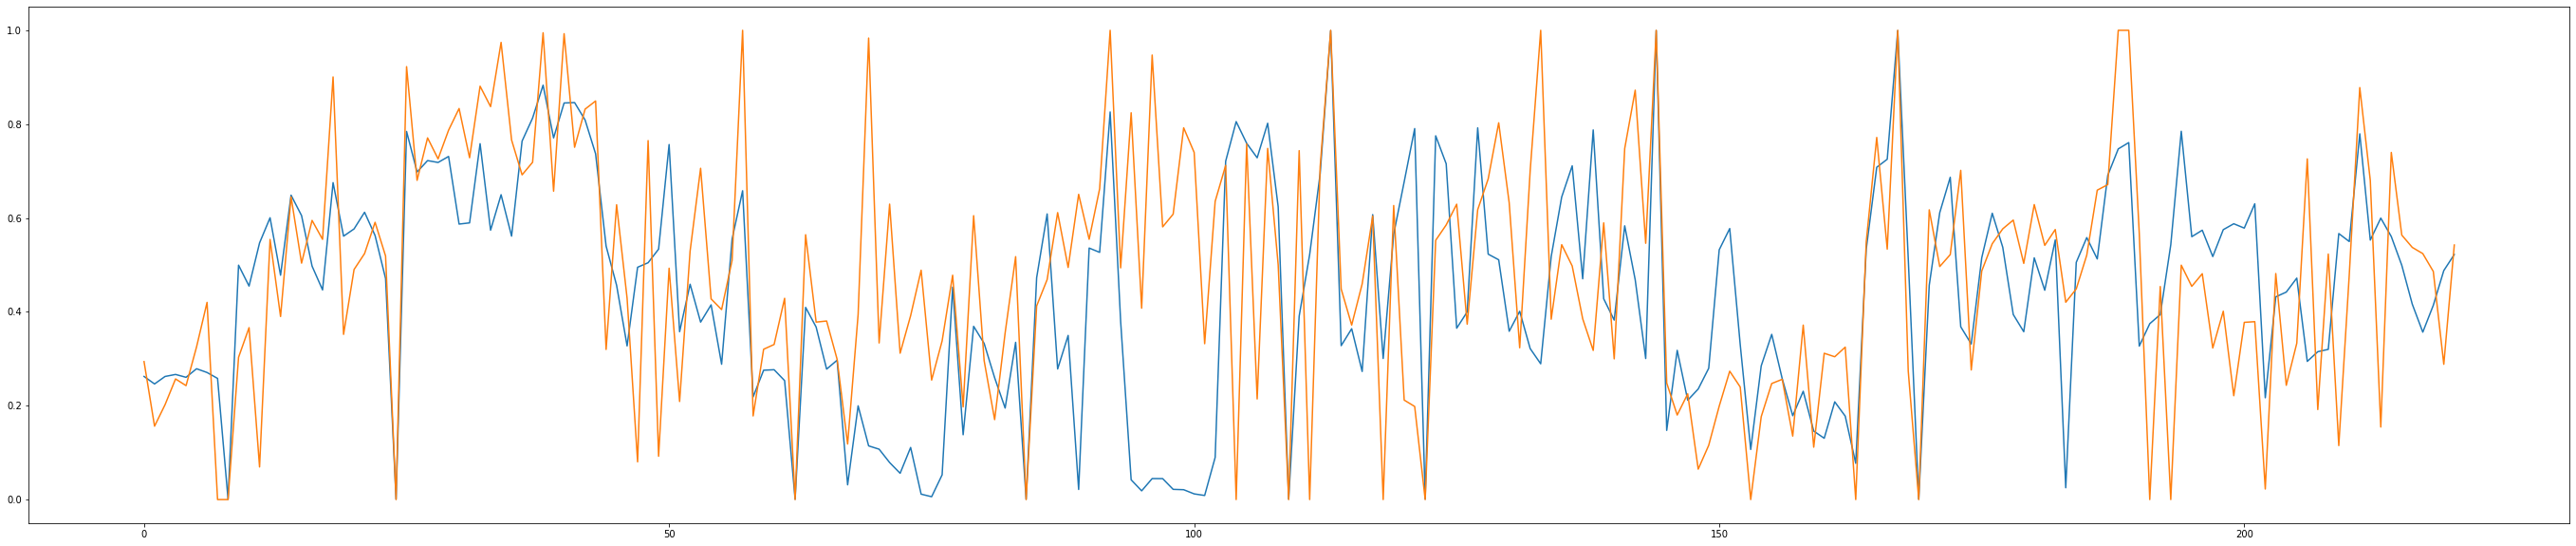

In [21]:
plt.figure(figsize=(48, 10))
plt.plot(result[9*len(result)//10:])
plt.plot(ground_truth[9*len(result)//10:])